# Data Analysis for 3DUI Honours Project Rotation Controllers
_By Steven Rybicki_

## Introduction

In [2]:
%matplotlib inline
import json
import os
import math
import csv
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd 
pd.options.display.max_colwidth = 500
from datetime import datetime
from scipy import stats
from collections import defaultdict, namedtuple
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import itertools

In [3]:
TASK_STAGES = [
    12,
    17,
    22
]

TRAINING_STAGES = [
    10,
    15,
    20
]

CONTROLLER_OPTIONS = [["discrete", "twoaxis", "arcball"], 
                      ["discrete", "arcball", "twoaxis"], 
                      ["twoaxis", "discrete", "arcball"], 
                      ["twoaxis", "arcball", "discrete"], 
                      ["arcball", "discrete", "twoaxis"], 
                      ["arcball", "twoaxis", "discrete"]]

MODEL_OPTIONS = [["models/mrt_model.json", "models/mrt_model_16a.json", "models/mrt_model_23a.json"], 
                 ["models/mrt_model.json", "models/mrt_model_23a.json", "models/mrt_model_16a.json"], 
                 ["models/mrt_model_16a.json", "models/mrt_model.json", "models/mrt_model_23a.json"], 
                 ["models/mrt_model_16a.json", "models/mrt_model_23a.json", "models/mrt_model.json"], 
                 ["models/mrt_model_23a.json", "models/mrt_model.json", "models/mrt_model_16a.json"], 
                 ["models/mrt_model_23a.json", "models/mrt_model_16a.json", "models/mrt_model.json"]]

INSPECTION_MODELS = ["models/ico_sphere_model_1.json",  
                     "models/ico_sphere_model_2.json", 
                     "models/ico_sphere_model_3.json", 
                     "models/ico_sphere_model_4.json", 
                     "models/ico_sphere_model_5.json"]

ORIENTATION_TASK_QUAT = {
    "0_0": [0.25881904510252074,0,0,0.9659258262890683],
    "0_1": [0,0,0.7071067811865475,0.7071067811865476],
    "0_2": [0.3314135740355918,0.4619397662556433,0.19134171618254486,0.8001031451912656],
    "0_3": [0.2185080122244105,0.21850801222441052,0.6724985119639573,0.6724985119639574],
    "1_0": [0.04799966634373737,0.7856544802373238,0.11573312388031406,-0.6058456187435991],
    "1_1": [-0.9124677834418226,0.3563393717894529,0.16246581417319952,-0.11844684680693215],
    "1_2": [0.060676044258967846,0.7425536630010398,-0.09767856431944423,-0.6598419305328469]
}

INSPECTION_TASK_QUAT = {
   # Right
   "2_4": [
        {"_x": 0.6037360617406411, "_y": 0.4867887259157211, "_z": 0.4852088982653913, "_w": -0.4038710550650234}, # i
        {"_x": -0.11248894296227391, "_y": 0.06028303996174144, "_z": -0.003373189735094837, "_w": 0.9918169258463039}, # ii       
        {"_x": -0.11174826532646152, "_y": -0.027786247141969745, "_z": -0.013321632568326447, "_w": 0.9932586691149524}, #ii
        {"_x": -0.7811102408938534, "_y": -0.01961503471099203, "_z": 0.1175362952920859, "_w": 0.6129170101025461}, # iii
        {"_x": -0.780783276818326, "_y": -0.07268886885317291, "_z": 0.050768701649669366, "_w": 0.6184790553595897}, # iii
        {"_x": -0.7749035265933994, "_y": -0.12204774719510819, "_z": -0.013785769906469866, "_w": 0.6200313092302658} # iii
    ],
    # Left
    "2_3":[
        {"_x": -0.00833871292136609, "_y": 0.7652087852958418, "_z": 0.004063556581182305, "_w": 0.6437153627813997}, # i
        {"_x": 0.1948499334671147, "_y": 0.754113368097429, "_z": 0.6162279869611768, "_w": 0.11666018845513774}, # ii
        {"_x": -0.14839942688648336, "_y": -0.7638058622785789, "_z": -0.6034981656185071, "_w": -0.1742646807122343}, # ii
        {"_x": 0.20596119891012116, "_y": -0.7545924538373429, "_z": 0.6200211133045981, "_w": -0.06118849738120929}, # iii
        {"_x": -0.1547361282111554, "_y": 0.7675820165970251, "_z": -0.609426932862735, "_w": 0.124392089477525}, # iii
        {"_x": 0.10206975688214842, "_y": -0.7753229466686666, "_z": 0.5947228958245248, "_w": -0.1864424047289847}, # iii
    ],
    # Back
    "2_2" : [
        {"_x": -0.029613511273988227, "_y": -0.9959613034779483, "_z": 0.08453278757996126, "_w": 0.006191102364907987}, # i
        {"_x": -0.11540244522140938, "_y": 0.045397514405298656, "_z": 0.01901363990593801, "_w": 0.9920986961085412}, # ii
        {"_x": -0.112556321254479, "_y": -0.0346808803313726, "_z": 0.009551699101593052, "_w": 0.9929939960187937}, # ii
        {"_x": -0.03859961323541416, "_y": -0.7750926112640198, "_z": -0.12904713390161232, "_w": 0.6173235383927773}, # iii
        {"_x": -0.0837200176668557, "_y": -0.7725081123897988, "_z": -0.07063207613090679, "_w": 0.6254864385062631}, # iii
        {"_x": -0.1309944396554082, "_y": -0.7652335446523579, "_z": -0.013966990216109457, "_w": 0.6301293534683624}, # iii
    ],
    # Top
    "2_1": [
        {"_x": 0.7409727890022544, "_y": 0.23941413588589777, "_z": 0.19895308004920917, "_w": 0.5950276207329898}, # i
        {"_x": 0.7266398312917077, "_y": -0.26958936361201574, "_z": 0.5838591535971657, "_w": 0.24171185194033912}, # ii
        {"_x": -0.7066543608643184, "_y": 0.3123196225137307, "_z": -0.6060865997818791, "_w": -0.18909019337121336}, # ii
        {"_x": 0.6506928948316127, "_y": 0.4389487590260925, "_z": -0.25264848979678445, "_w": -0.56576628051565}, # iii
        {"_x": -0.6771995348130961, "_y": -0.3935147540315883, "_z": 0.30914304984814234, "_w": 0.5394233060769378}, # iii
        {"_x": -0.7023921164512765, "_y": -0.346548889764243, "_z": 0.36262006731939933, "_w": 0.5050305619737696}, # iii
    ],
    # Bottom
    "2_0": [
        {"_x": 0.7820467470152829, "_y": -0.034745384642642985, "_z": 0.0002240369371546896, "_w": -0.6222504267064023}, # i
        {"_x": 0.11044866065596898, "_y": -0.046994740721513086, "_z": 0.6864112877260672, "_w": -0.7172392430605443}, # ii
        {"_x": -0.05217425432717972, "_y": 0.10775035835081356, "_z": -0.679589110432064, "_w": 0.7237584876482142}, # ii
        {"_x": -0.4482753257179445, "_y": -0.6226779602416613, "_z": 0.42678939225293583, "_w": -0.478719338278834}, # iii
        {"_x": -0.4845375784017118, "_y": -0.594916507823405, "_z": 0.3853577861896457, "_w": -0.5126373576504399}, # iii
        {"_x": -0.5169595621635281, "_y": -0.5664420353830509, "_z": 0.3440537794764716, "_w": -0.5417778405091477}, # iii
    ]
}

MRT_ANSWERS =\
    [[1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [2, 4],
    [1, 4],
    [3, 4],
    [2, 3],
    [1, 2],
    [2, 4],
    [2, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 3],
    [1, 4],
    [2, 4],
    [2, 3],
    [1, 4],
    [1, 3]]
    
CONFOUNDING_CAT_COLS = [
    "controller_choice",
    "model_choice",
    "Biological Sex",
    "Faculty",
    #"Major",
    "What type of computer software do you own or use?  [Word processing]",
    "What type of computer software do you own or use?  [Statistics programs]",
    "What type of computer software do you own or use?  [Games]",
    "What type of computer software do you own or use?  [Art/drawing]",
    "Do you participate in any extra-curricular sports?",
    "Do you own any video game systems?",
    "Do you own a computer?",
    "How long have you owned/been using a computer?",
    "Frequency of use [Using a computer]",
    "Frequency of use [Purchasing software]",
    "Frequency of use [Use the internet]",
    "Frequency of use [Use any video game systems]",
    "Frequency of use [Play boardgames]",
    "Frequency of use [Use maps]",
    "Frequency of use [Use 3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]",
    "Proficiency or Skill [Using maps]",
    "Proficiency or Skill [Using computers]",
    "Proficiency or Skill [Playing video games]",
    "Proficiency or Skill [3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]",
    "Level of Degree",
    # Made up ones
    "Owns a video game system",
    "Number of consoles owned",
] 

CONFOUNDING_NUM_COLS = [
    "Age",
    "How many science courses (or modules) have you taken in the past year? (Please don't include maths courses in this total)",
    "How many maths courses (or modules) have you taken in the past year?",
    "What was your final Matric mark for Maths?",
    "What was your final Matric mark for English?",
]
    
CONTROLLERS = ["twoaxis","arcball","discrete"]

PRETTY_NAMES = {
    "q_0_0 accuracy":"Simple Matching X Accuracy",
    "q_0_1 accuracy":"Simple Matching Z Accuracy",
    "q_0_2 accuracy":"Simple Matching X+Y Accuracy",
    "q_0_3 accuracy":"Simple Matching Y+Z Accuracy",
    "q_1_0 accuracy":"Complex Matching 1 Accuracy",
    "q_1_1 accuracy":"Complex Matching 2 Accuracy",
    "q_1_2 accuracy":"Complex Matching 3 Accuracy",
    "q_2_0 accuracy":"Inspection Face 1 Accuracy",
    "q_2_1 accuracy":"Inspection Face 2 Accuracy",
    "q_2_2 accuracy":"Inspection Face 3 Accuracy",
    "q_2_3 accuracy":"Inspection Face 4 Accuracy",
    "q_2_4 accuracy":"Inspection Face 5 Accuracy",
    "q_0_0 time":"Simple Matching X Time",
    "q_0_1 time":"Simple Matching Z Time",
    "q_0_2 time":"Simple Matching X+Y Time",
    "q_0_3 time":"Simple Matching Y+Z Time",
    "q_1_0 time":"Complex Matching 1 Time",
    "q_1_1 time":"Complex Matching 2 Time",
    "q_1_2 time":"Complex Matching 3 Time",
    "q_2_0 time":"Inspection Face 1 Time",
    "q_2_1 time":"Inspection Face 2 Time",
    "q_2_2 time":"Inspection Face 3 Time",
    "q_2_3 time":"Inspection Face 4 Time",
    "q_2_4 time":"Inspection Face 5 Time",
    "q_0_0 score":"Simple Matching X Score",
    "q_0_1 score":"Simple Matching Z Score",
    "q_0_2 score":"Simple Matching X+Y Score",
    "q_0_3 score":"Simple Matching Y+Z Score",
    "q_1_0 score":"Complex Matching 1 Score",
    "q_1_1 score":"Complex Matching 2 Score",
    "q_1_2 score":"Complex Matching 3 Score",
    "q_2_0 score":"Inspection Face 1 Score",
    "q_2_1 score":"Inspection Face 2 Score",
    "q_2_2 score":"Inspection Face 3 Score",
    "q_2_3 score":"Inspection Face 4 Score",
    "q_2_4 score":"Inspection Face 5 Score",
    "q_0":"I think that I would like to use this system frequently",
    "q_1":"I found the system unnecessarily complex",
    "q_2":"I thought the system was easy to use",
    "q_3":"I think that I would need the support of a technical person to be able to use this system",
    "q_4":"I found the various functions in this system were well integrated",
    "q_5":"I thought there was too much inconsistency in this system",
    "q_6":"I would imagine that most people would learn to use this system very quickly",
    "q_7":"I found the system very cumbersome to use",
    "q_8":"I felt very confident using the system",
    "q_9":"I needed to learn a lot of things before I could get going with this system",
    "anova_p_val": "Anova P Value",
    "kruskal_p_val": "Kruskal-Wallis H-Test p-value",
}

DIRECTORY = "/Users/stevenrybicki/rotation-data-analysis/data/study"
FACTOR_FILE = "/Users/stevenrybicki/rotation-data-analysis/data/study/.clean_info.csv"
def FORMAT_FLOAT(x, prec=4):
    return ("{0:." + str(prec) + "f}").format(round(x, prec))

LATEX_OPTIONS = {
    "float_format": FORMAT_FLOAT,
    "escape": False,
}

In [4]:
Event = namedtuple('Event', ["meta", "data"])
EventMeta = namedtuple('EventMeta', ["uuid","pipeline_index","participant_number", "date"])
EventData = namedtuple('EventData', ["raw"])
MRTData = namedtuple('MRTData', ["marks", "score"])
SUSData = namedtuple('SUSData', ["marks", "adj_marks", "score", "total", "controller", "text"])
TaskData = namedtuple('TaskData', ["meta", "info", "score"]);
TaskMeta = namedtuple('TaskMeta', ["type", "num", "repetition", "date"])
TaskInfo = namedtuple('TaskInfo', ["controller", "group", "index", "model", "rotation", "quaternion"])
TaskScore = namedtuple('TaskScore', ["time", "accuracy"])
Experiment = namedtuple('Experiment', ["num", "controllers", "models", "controller_choice", "model_choice"])

In [5]:
# Mathematics objects used for calculating accuracy 

class Vector3(object):
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
    def to_tuple(self):
        return (self.x, self.y, self.z)
    
    def inner_prod(self, v):
        """
        Essentially a dot product
        """
        return sum(a*b for a,b in zip(self.to_tuple(), v.to_tuple()))
    
    def tait_to_q(self):
        """
        Treats the contents of the Vector as Tait-Bryan angles, and converts them to a quaternion
        """
        x,y,z = self.to_tuple()
        x = x / 2.0
        y = y / 2.0
        z = z / 2.0
        e_0 = np.cos(z) * np.cos(y) * np.cos(x) + np.sin(z) * np.sin(y) * np.sin(x)
        e_1 = np.cos(z) * np.cos(y) * np.sin(x) - np.sin(z) * np.sin(y) * np.cos(x)
        e_2 = np.cos(z) * np.sin(y) * np.cos(x) + np.sin(z) * np.cos(y) * np.sin(x)
        e_3 = np.sin(z) * np.cos(y) * np.cos(x) - np.cos(z) * np.sin(y) * np.sin(x)
        return Quaternion(e_1, e_2, e_3, e_0)

class Quaternion(Vector3):
    def __init__(self, x, y, z, w):
        super(Quaternion, self).__init__(x, y, z)
        self.w = w
    
    def to_tuple(self):
        return super(Quaternion, self).to_tuple() + (self.w,)
    
    def dist(self, q):
        """
        What is the minimum angle that would be required to convert this quaternion to q?
        """
        return np.arccos(2 * (self.inner_prod(q)**2) - 1)
    
    def inspec_dist(self, q):
        """
        Given these two quaternions, what is the minimum angle to between the two quaternions if we don't care about
        z rotations in the final axis?
        """
        eu_1 = self.to_tait()
        eu_2 = q.to_tait()
        eu_1.z = 0
        eu_2.z = 0
        eq_1 = eu_1.tait_to_q()
        eq_2 = eu_2.tait_to_q()
        return eq_1.dist(eq_2)
        
    def to_tait(self):
        """
        Convert this quaternion to a vector containing the Tait Bryan angles
        """
        e_1, e_2, e_3, e_0 = self.to_tuple()
        x_rot = np.arctan2((e_2 * e_3 + e_0 * e_1),1/2.0 - (e_1 ** 2 + e_2 ** 2))
        y_rot = np.arcsin(-2 * (e_1 * e_3 - e_0 * e_2))
        z_rot = np.arctan2((e_1 * e_2 + e_0 * e_3), 1/2.0 - (e_2 ** 2 + e_3 ** 2))
        return Vector3(x_rot, y_rot, z_rot)

In [6]:
# Functions for loading the data into people

def get_data(directory):
    """
    Gets the parsed json data for each file in the directory
    """
    def person_num_from(path):
        """
        Get the number from the path
        """
        return path.split("/")[-1].split(".")[0]
    
    def parse_path(path):
        """
        Takes a path, reads it in, gives back the JSON
        """
        data = None
        with open(path) as f:
            file_data = "\n".join(f.readlines()).strip() # remove final newline
            file_data = file_data[1:-1] # remove quotation signs
            data = json.loads(file_data)
        return data
    
    def paths(directory):
        """
        Gives all the paths in the directory that don't begin with "."
        """
        return list(
            map(
                lambda x: "{0}/{1}".format(directory, x), 
                filter(lambda x: x[0] != ".", os.listdir(directory))
            )
        )
    
    return list(
        map(
            lambda x: (person_num_from(x), parse_path(x)), 
            paths(directory))
    )

def get_factors(path):
    """
    Parse the factors file
    """
    factors = dict()
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            num = row["Participant no"]
            proc_row = {}
            for col in row:
                if col in CONFOUNDING_NUM_COLS and row[col]:
                    proc_row[col] = float(row[col]) 
                else:
                    proc_row[col] = row[col]
                    
            factors[num] = proc_row
    return factors

def build_people(data, factors):
    """
    From parsed json data, get a list of people
    """
    people = dict()
    for path, datum in data:
        for event in datum:
            person_num = path
            experiment_num = None
            meta = event[2]
            if "participant_number" in meta:
                experiment_num = meta["participant_number"]
            if person_num and experiment_num:
                if person_num not in people:
                    people[person_num] = Person(person_num, experiment_num)
                    if person_num in factors:
                        people[person_num].factors = factors[person_num]
                        
                people[person_num].add_event(event)
            
    return people

def process():
    """
    Convience function for running the above data processing functions on the specified folders/files
    """
    full_data = get_data(DIRECTORY)
    factors = get_factors(FACTOR_FILE)
    people = build_people(full_data, factors)
    return people

In [7]:
# Helper data processing functions

def gen_experiment(num):
    """
    Determine the order in which controllers and models were presented to a participant with a given number
    """
    controller_num = num % len(CONTROLLER_OPTIONS)
    model_num = int(num / len(MODEL_OPTIONS)) % len(MODEL_OPTIONS)
    controller_choice = CONTROLLER_OPTIONS[controller_num]
    model_choice = MODEL_OPTIONS[model_num]
    return Experiment(num, controller_choice, model_choice, controller_num, model_num)

def parse_date(js_date):
    """
    Example input date: "2015-09-03T20:03:09.429Z"
    This is then transformed to
    2015-09-03 20:03:09

    Which is then made into a python datetime object
    Gives all the paths in the directory that don't begin with "."
    """
    template = "%Y-%m-%d %H:%M:%S.%f"
    formatted_date = js_date.replace("T"," ").replace("Z","") + "000"
    return datetime.strptime(formatted_date, template)

class Person:
    """
    All the data for an individual person
    """
    def __init__(self, person_num, experiment_num):
        self.person_num = person_num # unique identifying number
        self.experiment = gen_experiment(experiment_num)
        self.events = []
        self.mrt_results = None
        self.sus_results = dict()
        self.tasks = defaultdict(lambda : defaultdict(dict))
        self.training_tasks = defaultdict(lambda : defaultdict(dict))
        self.factors = dict()
        self.event_fns = (
            ("mrt test results", self.process_mrt),
            ("sus evaluation results", self.process_sus),
            ("saving user task", self.process_task),
        )

    def process_mrt(self, event_meta, event_data):
        """
        Given an event containing MRT data, set the person's MRT results and return the marked MRT
        """
        if self.mrt_results:
            raise "Duplicate MRT results for {0}".format(self.person_num)
            
        template = "test_{0}_{1}"
        data = event_data[1]
        marks = []
        for i, answers in enumerate(MRT_ANSWERS):
            answer_1 = template.format(i, answers[0])
            answer_2 = template.format(i, answers[1])
            if all([((answer in data) and data[answer]) for answer in (answer_1, answer_2)]):
                marks.append(True)
            else:
                marks.append(False)
                
        mrt_data = MRTData(marks, marks.count(True))
        self.mrt_results = mrt_data
        return mrt_data

    def process_sus(self, event_meta, event_data):
        """
        Given an event containing SUS data, set the controller's SUS results and return the processed SUS data
        """
        controller = event_data[1]
        if controller in self.sus_results:
            raise "duplicate controller for {0}".format(self.person_num)
            
        # Load events
        data = event_data[2]
        marks = [None]*10
        adj_marks = [None]*10
        for key in data:
            if data[key] and key != "text":
               num, answer = [int(x) for x in key.split("_")]
               marks[num] = answer
        
        # Calculate score
        score = 0
        total = 0
        for i in range(len(marks)):
            if marks[i] != None:
                if i % 2 == 0:
                    adj_marks[i] = marks[i]
                else:
                    adj_marks[i] = 5 - (marks[i] + 1)
                score += adj_marks[i]
                total += 4
        score *= 2.5
        total *= 2.5

        sus_data = SUSData(marks, adj_marks, score, total, controller, data["text"] if "text" in data else "")
        self.sus_results[controller] = sus_data
        return sus_data

    def process_task(self, event_meta, event_data):
        # Data we can read straight off given data
        group = event_data[1]
        index = event_data[2]
        rotation = event_data[3]
        quaternion = event_data[4]
        stage = event_meta.pipeline_index
        time = (event_meta.date - self.events[-1].meta.date).total_seconds()

        # Data dependent on stage
        task_type = None
        task_group = None
        repetition = None
        container = None
        if stage in TASK_STAGES:
            task_type = "task"
            repetition = TASK_STAGES.index(stage)
            container = self.tasks
        elif stage in TRAINING_STAGES:
            task_type = "training"
            repetition  = TRAINING_STAGES.index(stage)
            container = self.training_tasks
            
        controller = self.experiment.controllers[repetition]
        model = self.experiment.models[repetition] if group < 2 else INSPECTION_MODELS[index]
        num = len(container[controller])
        
        # Calculate accuracy
        accuracy = None
        key = "{0}_{1}".format(group, index)
        if task_type == "training":
            accuracy = 0 # ignore these for training data
        else:
            their_quat = Quaternion(*quaternion)
            if group < 2:
                task_group = "orientation"
                model_quat = ORIENTATION_TASK_QUAT[key]
                accuracy = Quaternion(*model_quat).dist(their_quat)
            else:
                task_group = "inspection"
                quat = INSPECTION_TASK_QUAT[key][0]
                model_quat = Quaternion(quat["_x"], quat["_y"], quat["_z"], quat["_w"])
                accuracy = model_quat.inspec_dist(their_quat)
                
        if accuracy > math.pi:
            print(accuracy,  2*math.pi - accuracy)
            accuracy = 2*math.pi - accuracy
            
        # Setup tuples
        score = TaskScore(time, accuracy)
        info = TaskInfo(controller, group, index, model, rotation, quaternion)
        meta = TaskMeta(task_group, num, repetition, event_meta.date)
        task_data = TaskData(meta, info, score)
        
        container[controller][group][index] = task_data
        return task_data

    def add_event(self, event):
        event_meta = EventMeta(
                event[2]["uuid"],
                event[2]["pipeline_index"],
                event[2]["participant_number"],
                parse_date(event[1]))

        event_data = EventData(event[3:])
        for name, fn in self.event_fns:
            if name == event[3]:
                event_data = fn(event_meta, event[3:])
                break

        processed_event = Event(event_meta, event_data)
        self.events.append(processed_event)

    def validate(self):
        num_mrt = len(self.mrt_results)
        sus_keys = self.sus_results.keys()
        num_sus = len(self.sus_results)
        totals_sus = [self.sus_results[key].total for key in self.sus_results]
        valid_elms = (
          num_mrt == 1,
          sus_keys == set(CONTROLLERS),
          num_sus == 3,
          all(total == 100 for total in totals_sus),
        )
        valid = all(valid_elms)
        return valid

In [8]:
# Converting people data into dataframes, then manipulating those data frames

def get_df(people):
    """
    Given a list of people, get dataframes to represent them
    """
    people_data = []
    people_indices = []
    task_data = []
    sus_data = []
    for num in people:
        # create person datum
        person = people[num]
        people_indices.append(num)
        person_data = {
            "mrt_score": person.mrt_results.score,
            "controller_choice": person.experiment.controller_choice, 
            "model_choice": person.experiment.model_choice,
            "valid": person.validate()
        }
        
        for factor in person.factors:
            factor_data = person.factors[factor]
            if factor == "Do you own any video game systems?":
                if factor_data:
                    person_data["Owns a video game system"] = "yes"
                    person_data["Number of consoles owned"] = len(factor_data.split(","))
                else:
                    person_data["Owns a video game system"] = "no"
                    person_data["Number of consoles owned"] = 0                
            
            if factor_data: # ignore incompleted questions
                person_data[factor] = person.factors[factor]
        
        people_data.append(person_data)
        
        # create task datum
        for controller in person.tasks:
            for group in person.tasks[controller]:
                for index in person.tasks[controller][group]:
                    task = person.tasks[controller][group][index]
                    task_data.append({
                            "Task Class": "Simple" if group == 0 else ("Complex" if group == 1 else "Inspection"),
                            "person_num": num,
                            "controller": controller,
                            "group": group,
                            "index": index,
                            "type": task.meta.type,
                            "num_done": task.meta.num,
                            "repetition": task.meta.repetition, 
                            "date": task.meta.date,
                            "model": task.info.model,
                            "quaternion": task.info.quaternion,
                            "time": task.score.time,
                            "accuracy": task.score.accuracy,
                            "score": (math.pi - task.score.accuracy) / task.score.time if task.score.time else np.NAN
                    })
        
        # create sus datum
        if not all(person.sus_results[controller].total == 100 for controller in CONTROLLERS):
            print("discarding SUS results of ", num)
            continue
        for controller in CONTROLLERS:
            sus_result = person.sus_results[controller]
            sus_datum = {
                "person_num": num,
                "score": sus_result.score,
                "total": sus_result.total,
                "controller": controller,
                "text": sus_result.text,
            }
            for i, mark in enumerate(sus_result.adj_marks):
                sus_datum["q_{0}".format(i)] = mark
            sus_data.append(sus_datum)                

    people_df = pd.DataFrame(people_data, index=people_indices)
    task_df = pd.DataFrame(task_data)
    sus_df = pd.DataFrame(sus_data)
    return (people_df, task_df, sus_df)

In [9]:
people = process()
df = get_df(people)
people_df = df[0]
task_df = df[1]
sus_df = df[2]
full_tasks_df = task_df.join(people_df, on="person_num")

('discarding SUS results of ', '30')


In [10]:
# Cleaning up questionairre answers
answers = {}
for cat in CONFOUNDING_CAT_COLS:
    answers[cat] = [answer for answer, group in people_df.groupby(cat)]

for cat in answers:
    print(cat, answers[cat])

('controller_choice', [0, 1, 2, 3, 4, 5])
('How long have you owned/been using a computer?', ['1 to 3 years', '3 or more years'])
('Frequency of use [Use 3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]', ['1 to 2X a month', '1 to 2X a year', '1 to 2X in 6 months', 'Daily', 'Once every few years to not at all', 'Weekly'])
('Do you own a computer?', ['No', 'Yes'])
('What type of computer software do you own or use?  [Statistics programs]', ['No', 'Yes'])
('Frequency of use [Use maps]', ['1 to 2X a month', '1 to 2X in 6 months', 'Daily', 'Once every few years to not at all', 'Weekly'])
('Proficiency or Skill [Playing video games]', ['Moderately skilled', 'No skill', 'Not very skilled', 'Very skilled'])
('Do you participate in any extra-curricular sports?', ['College-level sports', 'Intramural team'])
('Owns a video game system', ['no', 'yes'])
('Proficiency or Skill [Using maps]', ['Moderately skilled', 'No skill', 'Not very skilled', 'Very skilled'])
('Frequency of

In [11]:
GrubbsOutlierTestResult = namedtuple('GrubbsOutlierTestResult', ["G", "G_test", "outlier_present"])

def grubbs_outlier_test(y_i, alpha=0.9999):
    """
    Perform Grubb-Smirnov outlier test on data
    
    Based off of that from from https://github.com/choderalab/cadd-grc-2013/blob/master/notebooks/Outliers.ipynb
    as well as wikipedia: https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers
    """
    s = y_i.std()
    G = ((np.abs(y_i - y_i.mean())) / s).max()
    N = y_i.size
    t = stats.t.isf(1 - alpha/(2*N), N-2) # Upper critical value of the t-distribution with N − 2 degrees of freedom and a significance level of α/(2N)
    G_test = ((N-1)/np.sqrt(N)) * np.sqrt(t**2 / (N-2 + t**2))
    return GrubbsOutlierTestResult(G, G_test, G > G_test)


def get_outlier_indices(group, rows):
    indices = []
    identity_cols = ["person_num", "group", "index"]

    for row in rows:
        outlier_info = group.loc[row][identity_cols]
        indices.extend(list(group[(group["person_num"] == outlier_info["person_num"]) & \
                        (group["group"] == outlier_info["group"]) & \
                        (group["index"] == outlier_info["index"])].index))
    return indices    



def remove_outliers_grubbs(t_df, alpha=0.9999):
    """
    Given a task_df like object, remove its outliers in a copy
    """
    test_df = full_tasks_df.copy(deep=True)
    measures = ["accuracy", "time"]
    task_types = test_df["type"].unique()
    for task_type in task_types:
        for measure in measures:
            i = 0
            group = test_df[test_df["type"] == task_type]
            result = grubbs_outlier_test(group[measure])
            while result.outlier_present:
                indices = get_outlier_indices(group, [group[measure].idxmax()])
                print "Removing", task_type, measure, i, max(test_df.loc[indices][measure])#, result
                i += 1
                test_df = test_df.drop(indices)
                group = test_df[test_df["type"] == task_type]
                result = grubbs_outlier_test(group[measure])
    return test_df

def remove_outliers_set(t_df, limits):
    test_df = full_tasks_df.copy(deep=True)
    task_types = test_df["type"].unique()
    for task_type in task_types:
        for measure in limits[task_type]:
            limit = limits[task_type][measure]
            indices = get_outlier_indices(test_df, 
                        list(test_df[
                            (test_df["type"] == task_type) & \
                            (test_df[measure] > limit)].index))
            test_df = test_df.drop(indices)
    return test_df
            
#temp_grubbs_df = remove_outliers_grubbs(full_tasks_df)
temp_limit_df = remove_outliers_set(full_tasks_df, 
                    {"orientation":{"accuracy": 0.5}, 
                     "inspection":{"accuracy": 0.5}})
print len(full_tasks_df), len(full_tasks_df) - len(temp_limit_df.index), 1 - len(temp_limit_df.index)/ float(len(full_tasks_df))

1620 138 0.0851851851852


In [12]:
def calc_w_from(t, n):
    S = (n*(n - 1))/2
    S_u = t
    S_f = S - S_u
    return abs(S_f - S_u)

def calc_effect_t(t, n):
    # effect calculated using http://www.amsciepub.com/doi/pdf/10.2466/11.IT.3.1
    w = calc_w_from(t, n)
    return calc_effect_w(w, n)

def calc_effect_w(w, n):
    S = (n*(n-1))/2
    return w / float(S)

def mann_whitney_effect(U, a, b):
    return 1 - (2*U)/float(len(a.values) * len(b.values))

def get_diff_performers(df):
    entries = []
    indices = []
    for measure in ["accuracy", "time", "score"]:
        for values, group in df.groupby(["type", "controller"]):
            task_type, controller = values
            for cat in CONFOUNDING_CAT_COLS:
                values = []
                names = []
                for cat_name, g in group.groupby(cat):
                    values.append(g[measure])
                    names.append(cat_name)
                if len(values) == 1:
                    continue
                H,p = stats.mstats.kruskalwallis(*values)
                if p < 0.05:
                    for i in range(len(names) - 1):
                        for j in range(i + 1, len(names)):
                            n_1 = names[i]
                            n_2 = names[j]
                            v_1 = values[i]
                            v_2 = values[j]
                            if len(v_1.values) < 20 or len(v_2.values) < 20:
                                continue
                            U, p = stats.mannwhitneyu(v_1, v_2)
                            if p < (0.05 / len(values)):
                                entries.append({
                                    "controller": controller,
                                    "type": task_type,
                                    "measure": measure,
                                    "cat": cat,
                                    "name_1": n_1,
                                    "name_2": n_2,
                                    "n_1": len(v_1.values),
                                    "n_2": len(v_2.values),
                                    "m_1": v_1.median(),
                                    "m_2": v_2.median(),
                                    "p": p,
                                    "r": mann_whitney_effect(U, v_1, v_2)
                                })
                    
                
    return pd.DataFrame(entries) 

def get_comparison_performers(df, cols):
    entries = []
    controllers = df["controller"].unique()
    for measure in ["accuracy", "time", "score"]:
        for task_type, group in df.groupby(["type"]):
            for cat in cols:
                for cat_name, g in group.groupby(cat):
                    g = g.sort(["person_num","group","index"])
                    values = []
                    for controller in controllers:
                        values.append(g[g["controller"] == controller][measure])
                    
                    _, p_val = stats.friedmanchisquare(*values)
                    if p_val < 0.05:
                        for i in range(len(controllers) - 1):
                            for j in range(i + 1, len(controllers)):
                                c_1 = controllers[i]
                                c_2 = controllers[j]
                                v_1 = values[i]
                                v_2 = values[j]
                                n_1 = len(v_1.values)
                                n_2 = len(v_2.values)
                                if n_1 < 20 or n_2 < 20:
                                    continue
                                T, p = stats.wilcoxon(v_1.values, v_2.values)
                                W = calc_w_from(T, n_1)
                                if p > (0.05 / len(values)):
                                    continue
                                
                                m_1 = v_1.median()
                                m_2 = v_2.median()
                                r = calc_effect_w(W, len(v_1.values))
                                m_diff = m_1 - m_2
                                
                                ov_1, ov_2 = group[group["controller"] == c_1][measure], group[group["controller"] == c_2][measure]
                                om_1, om_2 = ov_1.median(), ov_2.median()
                                oT, oP = stats.wilcoxon(ov_1.values, ov_2.values)
                                oR = calc_effect_t(oT, len(ov_1.values))
                                om_diff = om_1 - om_2
                                
                                r_diff = abs(r - oR)
                                
                                ratio = m_diff / float(om_diff)
                                if (ratio > 0):# or (r_diff < 0.1):
                                    continue
                                                                                  
                                entries.append({
                                        "cat_name": cat_name,
                                        "type": task_type,
                                        "measure": measure,
                                        "cat": cat,
                                        "c_1": c_1,
                                        "c_2": c_2,
                                        "n_1": n_1,
                                        "n_2": n_2,
                                        "m_1": m_1,
                                        "m_2": m_2,
                                        "om_1": om_1,
                                        "om_2": om_2,
                                        "p": p,
                                        "r": r,
                                        "ratio": ratio,
                                        "oR": oR,
                                        "m_diff": m_diff,
                                        "om_diff": om_diff,
                                        "r_diff": r_diff,
                                })
                    
                
    return pd.DataFrame(entries)  

performers_df = get_diff_performers(temp_limit_df)
cols = performers_df["cat"].unique()
comparison_df = get_comparison_performers(temp_limit_df, CONFOUNDING_CAT_COLS)

In [13]:
comparison_df
#for cat, group in  performers_df.groupby("cat"):
#    print(group.sort(["name_1","name_2", "measure", "type", "r"]))
#performers_df.sort(["r"])

,c_1,c_2,cat,cat_name,m_1,m_2,m_diff,measure,n_1,n_2,oR,om_1,om_2,om_diff,p,r,r_diff,ratio,type
0,arcball,twoaxis,controller_choice,2,17.693000,22.801000,-5.108000,time,51,51,0.006733,19.112000,18.319500,0.792500,0.001800,0.482353,0.475620,-6.445426,orientation
1,arcball,twoaxis,Do you participate in any extra-curricular sports?,Intramural team,19.446000,22.305000,-2.859000,time,75,75,0.006733,19.112000,18.319500,0.792500,0.007905,0.335495,0.328762,-3.607571,orientation
2,arcball,twoaxis,Frequency of use [Play boardgames],1 to 2X a year,19.202000,25.051000,-5.849000,time,40,40,0.006733,19.112000,18.319500,0.792500,0.011953,0.428205,0.421472,-7.380442,orientation
3,arcball,twoaxis,"Proficiency or Skill [3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]",No skill,17.318500,18.319500,-1.001000,time,102,102,0.006733,19.112000,18.319500,0.792500,0.003471,0.320132,0.313399,-1.263091,orientation
4,arcball,twoaxis,Frequency of use [Purchasing software],1 to 2X a year,0.525641,0.425652,0.099989,score,54,54,0.004432,0.420267,0.425262,-0.004995,0.012679,0.366876,0.362445,-20.017720,inspection
5,arcball,twoaxis,controller_choice,2,0.174958,0.131925,0.043033,score,51,51,0.001331,0.156670,0.164484,-0.007814,0.006025,0.419608,0.418277,-5.507205,orientation
6,arcball,twoaxis,Do you participate in any extra-curricular sports?,Intramural team,0.156886,0.138832,0.018054,score,75,75,0.001331,0.156670,0.164484,-0.007814,0.003382,0.372973,0.371642,-2.310439,orientation


In [14]:
import statsmodels.formula.api as smf

def forward_selected(data, response, cols_to_ignore):
    """
    Based off of the code from http://planspace.org/20150423-forward_selection_with_statsmodels/
    by https://github.com/ajschumacher
    """
    format_col = lambda x: "C(Q(\"{}\"))".format(x) \
                     if x in CONFOUNDING_CAT_COLS \
                     else "Q(\"{}\")".format(x)
    selected_cols = set(data.columns)
    selected_cols.remove(response)
    selected_cols -= set(cols_to_ignore)
    remaining = set(format_col(x) for x in selected_cols)
    formatted_response = format_col(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(formatted_response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        elif current_score == best_new_score:
            break
    formula = "{} ~ {} + 1".format(formatted_response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [15]:
# Finding the best model for task accuracy and time using forward selection
for task_type, group in temp_limit_df.groupby("type"):
    q_cols = ["time", "accuracy", "score"]
    cols_to_ignore = q_cols + ["Email Address", "Name (First name and surname)", "Timestamp", "Major", "date", "group", "index", "model", "person_num", "quaternion", "type", "Participant no", 'valid']
    for question_col in q_cols:
        print(task_type + " " + question_col + "\n" + "="*(len(task_type + question_col) + 1 ))
        model = forward_selected(group, question_col, cols_to_ignore)
        print(model.rsquared_adj, model.model.formula)

inspection time
(0.50467884188900747, 'Q("time") ~ C(Q("Frequency of use [Use maps]")) + Q("How many maths courses (or modules) have you taken in the past year?") + C(Q("Do you participate in any extra-curricular sports?")) + Q("How many science courses (or modules) have you taken in the past year? (Please don\'t include maths courses in this total)") + Q("controller") + Q("repetition") + Q("Task Class") + 1')
inspection accuracy
(0.26944622711205113, 'Q("accuracy") ~ C(Q("controller_choice")) + Q("How many science courses (or modules) have you taken in the past year? (Please don\'t include maths courses in this total)") + C(Q("Do you participate in any extra-curricular sports?")) + Q("controller") + C(Q("Do you own any video game systems?")) + Q("repetition") + 1')
inspection score
(0.41183923545013457, 'Q("score") ~ C(Q("Do you own any video game systems?")) + Q("What was your final Matric mark for Maths?") + C(Q("Do you participate in any extra-curricular sports?")) + Q("How many ma

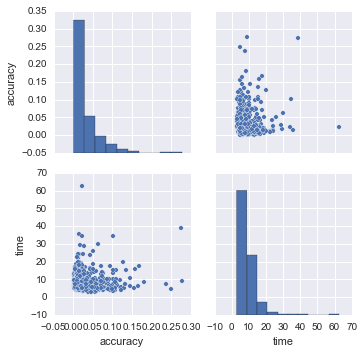

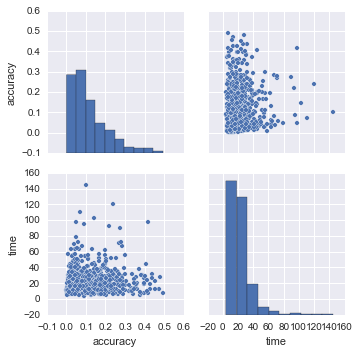

In [16]:
# Take a look at the data
for task_type, group in temp_limit_df.groupby("type"):
    clean = group[["accuracy", "time"]]
    sns.pairplot(clean)

In [17]:
# Run normal tests for all the data
for measure in ["time","accuracy","score"]:
    print stats.normaltest(temp_limit_df[measure])
print(stats.normaltest(sus_df["score"]))

NormaltestResult(statistic=1000.0690020296418, pvalue=6.8829632067800628e-218)
NormaltestResult(statistic=518.5031774809886, pvalue=2.5613302894329317e-113)
NormaltestResult(statistic=197.4524360651063, pvalue=1.3296835295207079e-43)
NormaltestResult(statistic=13.535317121952444, pvalue=0.0011503850564255271)


In [18]:
# Go through qualitative feedback
sus_df[sus_df["text"] != ""]
with pd.option_context('display.max_rows', 999):
    for index, row in sus_df[sus_df["text"] != ""][["person_num", "controller", "text"]].iterrows():
        pass#print (row["person_num"],row["controller"],row["text"])

In [19]:
index_map = {   
    ('inspection', '', ''): "Inspection",
    ('orientation', '', ''): "Orientation",
    ('inspection', 2, ''): "TODO DELETE ME",
    ('orientation', 0, ''): "\hspace*{0.25cm} Simple",
    ('orientation', 1, ''): "\hspace*{0.25cm} Complex",
    ('inspection', 2, 0): "\hspace*{0.25cm} Bottom",
    ('inspection', 2, 1): "\hspace*{0.25cm} Top",
    ('inspection', 2, 2): "\hspace*{0.25cm} Back",
    ('inspection', 2, 3): "\hspace*{0.25cm} Left",
    ('inspection', 2, 4): "\hspace*{0.25cm} Right",
    ('orientation', 0, 0): "\hspace*{0.5cm} X",
    ('orientation', 0, 1): "\hspace*{0.5cm} Z",
    ('orientation', 0, 2): "\hspace*{0.5cm} X + Y",
    ('orientation', 0, 3): "\hspace*{0.5cm} Y + Z",
    ('orientation', 1, 0): "\hspace*{0.5cm} 1",
    ('orientation', 1, 1): "\hspace*{0.5cm} 2",
    ('orientation', 1, 2): "\hspace*{0.5cm} 3",
    "q_0":"I think that I would like to use this system frequently",
    "q_1":"I found the system unnecessarily complex",
    "q_2":"I thought the system was easy to use",
    "q_3":"I think that I would need the support of a technical person to be able to use this system",
    "q_4":"I found the various functions in this system were well integrated",
    "q_5":"I thought there was too much inconsistency in this system",
    "q_6":"I would imagine that most people would learn to use this system very quickly",
    "q_7":"I found the system very cumbersome to use",
    "q_8":"I felt very confident using the system",
    "q_9":"I needed to learn a lot of things before I could get going with this system",
    "score": "Total Score",
}

index_order = [
    "Orientation",
    "\hspace*{0.25cm} Simple",
    "\hspace*{0.5cm} X",
    "\hspace*{0.5cm} Z",
    "\hspace*{0.5cm} X + Y",
    "\hspace*{0.5cm} Y + Z",
    "\hspace*{0.25cm} Complex",
    "\hspace*{0.5cm} 1",
    "\hspace*{0.5cm} 2",
    "\hspace*{0.5cm} 3",
    "Inspection",
    "\hspace*{0.25cm} Bottom",
    "\hspace*{0.25cm} Top",
    "\hspace*{0.25cm} Back",
    "\hspace*{0.25cm} Left",
    "\hspace*{0.25cm} Right",
]


header = \
"""\\begin{tabular}{L{1.75cm}L{1.25cm}L{1cm}L{1.25cm}L{1.25cm}L{1.25cm}L{1cm}L{1cm}L{1cm}L{1cm}L{1cm}L{1cm}}
{} & \multicolumn{2}{c}{Friedman test} & \multicolumn{3}{c}{Median} & \multicolumn{2}{c}{Arcball, Discrete} & \multicolumn{2}{c}{Arcball, Two Axis} &  \multicolumn{2}{c}{Discrete, Two Axis} \\\\
{} & $\chi^2 (2)$ & $p$ & {Arcball} & {Discrete} & {Two Axis} & $p$ & $r$ & $p$ & $r$& $p$ & $r$ \\\\
"""

no_pair_header = """\\begin{tabular}{L{10cm}lllll}
{} & \multicolumn{2}{c}{Friedman test} & \multicolumn{3}{c}{Median} \\\\
{} & $\chi^2 (2)$ & $p$ & {Arcball} & {Discrete} & {Two Axis} \\\\
"""

def bold_text(text):
    return "\\emph{{{0}}}".format(text)

def report_group(group, measure, pairs = True):
            entry = {}
            c_vals = []
            c_names = []
            for controller, g in group.groupby("controller"):
                g = g.sort(["person_num","group","index"])
                c_vals.append(g[measure])
                c_names.append(controller)
            
            for i, controller in enumerate(c_names):
                entry[format_median_col(controller)] = FORMAT_FLOAT(c_vals[i].median())
            
            f_chi, p_val = stats.friedmanchisquare(*c_vals)
            formatted_p_val = FORMAT_FLOAT(p_val)
            formatted_f_chi = FORMAT_FLOAT(f_chi)
            if(p_val < 0.05):
                formatted_p_val = bold_text(formatted_p_val)
                formatted_f_chi = bold_text(formatted_f_chi)
            
            entry["p"] = formatted_p_val
            entry["$\chi$"] = formatted_f_chi
            if pairs:
                for c_1, c_2 in itertools.combinations(zip(c_names, c_vals), 2):
                    c_name1, c_vals1 = c_1
                    c_name2, c_vals2 = c_2
                    n_1, n_2 = len(c_vals1), len(c_vals2)
                    T, p = stats.wilcoxon(x=c_vals1, y=c_vals2)
                    r = calc_effect_t(T, len(c_vals1.values))
                    formatted_p = FORMAT_FLOAT(p)
                    formatted_r = FORMAT_FLOAT(r)
                    if p < (0.05/3):
                        formatted_p = bold_text(formatted_p)
                        formatted_r = bold_text(formatted_r)
                    entry[format_diff_col(c_name1, c_name2, "p")] = formatted_p
                    entry[format_diff_col(c_name1, c_name2, "r")] = formatted_r
            return entry

def build_measure_report(df, break_down_cols, measure):
    entries = []
    indices = []
    current_cols = []
    indices_names = list(break_down_cols)
    break_down_cols.reverse()
    while break_down_cols:
        current_cols.append(break_down_cols.pop())
        for vals, group in df.groupby(current_cols):
            if type(vals) is str:
                vals = (vals,)
            index = tuple(vals) + ("",)*len(break_down_cols)
            entries.append(report_group(group, measure))
            indices.append(index_map[index])
    return pd.DataFrame(entries, indices)

def format_median_col(controller):
    return "{}".format(controller)

def format_diff_col(c_name1, c_name2, m_name):
    return "{} \\newline {} {}".format(c_name1, c_name2, m_name)

def display_measure_report(df):
    df = df.drop(u'TODO DELETE ME')
    df = df.reindex(index_order)
    return display_report(df)

def display_report(df, pairs = True):
    controllers = ["arcball", "discrete", "twoaxis"]
    controller_pairs = itertools.combinations(controllers, 2)
    col_order = ["$\chi$","p"]+ \
        [format_median_col(c) for c in controllers]
    if pairs:
        col_order += [format_diff_col(c[0], c[1], m) for c in controller_pairs for m in ["p", "r"]]
    report_str = df[col_order].to_latex(**LATEX_OPTIONS)
    report_lines = report_str.split("\n")
    report_lines = report_lines[3:] # remove header
    h = header if pairs else no_pair_header
    report_str = h + ("\n".join(report_lines))
    return report_str 

def gen_sus_report(df):
    entries = []
    indices = []
    cols = ["q_{0}".format(i) for i in range(10)] + ["score"]
    for col in cols:
        entries.append(report_group(df, col, pairs=False))
        indices.append(index_map[col])
    return pd.DataFrame(entries, indices)
    

for measure in ["accuracy","time","score"]:
    report = build_measure_report(temp_limit_df, ["type","group","index"], measure)
    print display_measure_report(report)
    
#sus_report = gen_sus_report(sus_df)
#print display_report(sus_report, pairs = False)


\begin{tabular}{L{1.75cm}L{1.25cm}L{1cm}L{1.25cm}L{1.25cm}L{1.25cm}L{1cm}L{1cm}L{1cm}L{1cm}L{1cm}L{1cm}}
{} & \multicolumn{2}{c}{Friedman test} & \multicolumn{3}{c}{Median} & \multicolumn{2}{c}{Arcball, Discrete} & \multicolumn{2}{c}{Arcball, Two Axis} &  \multicolumn{2}{c}{Discrete, Two Axis} \\
{} & $\chi^2 (2)$ & $p$ & {Arcball} & {Discrete} & {Two Axis} & $p$ & $r$ & $p$ & $r$& $p$ & $r$ \\
\midrule
Orientation              &  \emph{12.7357} &  \emph{0.0017} &  0.0981 &   0.0863 &  0.0958 &               \emph{0.0096} &               \emph{0.1727} &                     0.3142 &                     0.0627 &                      0.0781 &                      0.1152 \\
\hspace*{0.25cm} Simple  &  \emph{15.5404} &  \emph{0.0004} &  0.0874 &   0.0603 &  0.0842 &               \emph{0.0008} &               \emph{0.2957} &                     0.3982 &                     0.0652 &                      0.0251 &                      0.1936 \\
\hspace*{0.5cm} X        &  \emph{17.3023} &  \em

In [20]:
print(len(CONFOUNDING_CAT_COLS))
total_strat = 0
for cat in CONFOUNDING_CAT_COLS:
    for cat_name, group in temp_limit_df.groupby(cat):
        total_strat += 1
        
print total_strat

26
97


In [21]:
def get_sus_positions(df):
    entries = []
    indices = []
    for person_num, group in sus_df.groupby("person_num"):
        indices.append(person_num)
        scores = []
        for controller in ["twoaxis","arcball","discrete"]:
            scores.append(group[group["controller"] == controller]["score"].values[0])
        ranks = stats.rankdata(scores)
        positions = {controller: rank for controller, rank in zip(["twoaxis","arcball","discrete"], ranks)}
        entries.append(positions)
    return pd.DataFrame(entries, indices)
    
pos_df = get_sus_positions(sus_df)

FriedmanchisquareResult(statistic=0.31952662721899949, pvalue=0.8523455036744304)

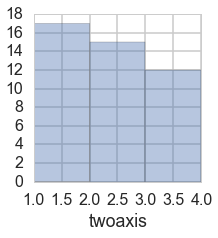

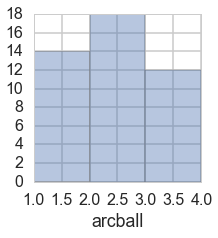

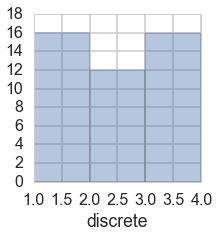

In [38]:
bins = [1, 2, 3,4]
for controller in ["twoaxis","arcball","discrete"]:
    plot = plt.figure(figsize=(3,3))
    plt.ylim([0, 18])
    sns.distplot(pos_df[controller], kde=False, bins=bins)
stats.friedmanchisquare(*[pos_df[controller].values for controller in ["twoaxis","arcball","discrete"]])

\subfloat[][]{
        \includegraphics[]{pictures/new_box_accuracy.pdf}
    }
\subfloat[][]{
        \includegraphics[]{pictures/bar_accuracy.pdf}
    }
\subfloat[][]{
        \includegraphics[]{pictures/new_box_time.pdf}
    }
\subfloat[][]{
        \includegraphics[]{pictures/bar_time.pdf}
    }
\subfloat[][]{
        \includegraphics[]{pictures/new_box_score.pdf}
    }
\subfloat[][]{
        \includegraphics[]{pictures/bar_score.pdf}
    }


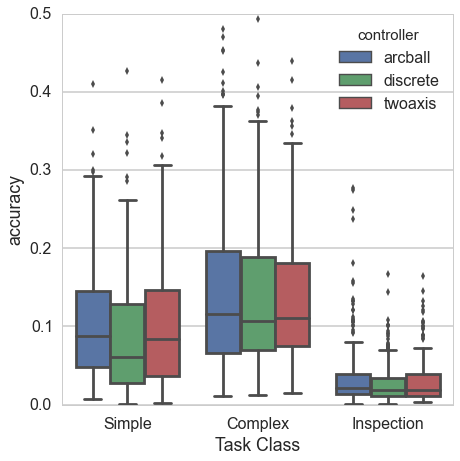

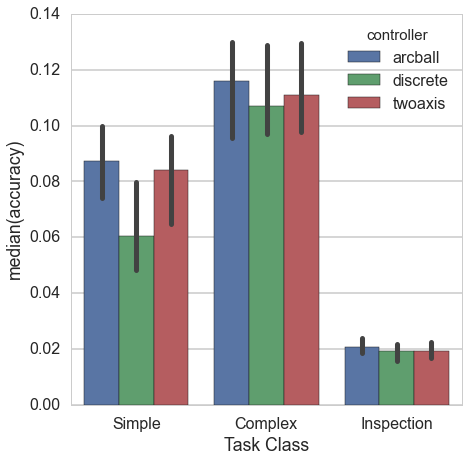

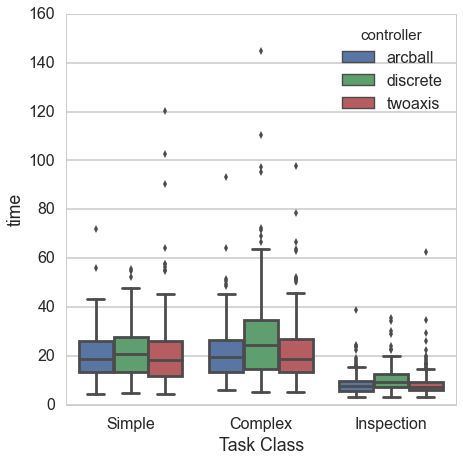

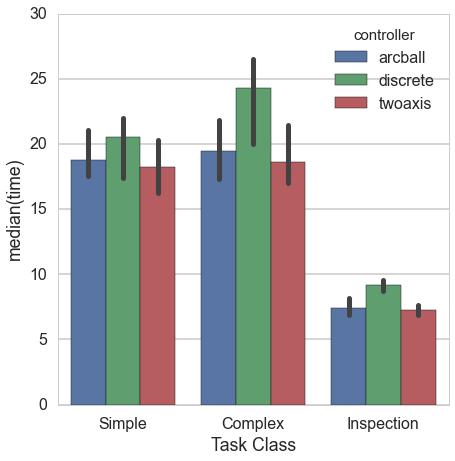

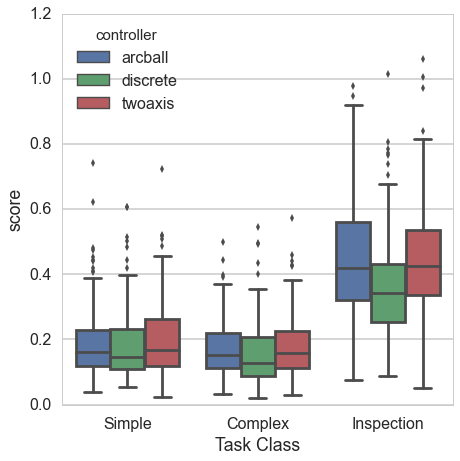

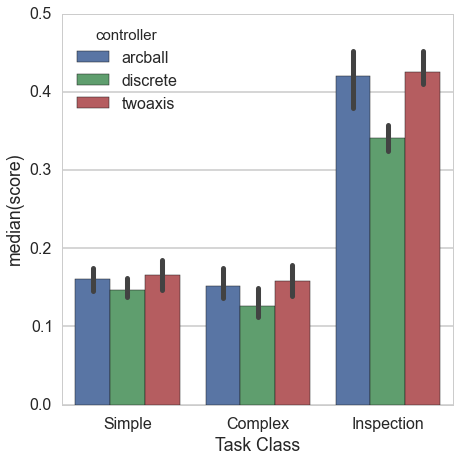

In [49]:
def save_figure(plot, name):
    name += ".pdf"
    plot.savefig(name, bbox_inches='tight')
    print("""\subfloat[][]{{
        \includegraphics[]{{pictures/{0}}}
    }}""".format(name))

sns.set_context("poster")
sns.set_style("whitegrid")
limits = {"accuracy": 0.5,
            "time": 160,
            "score": 1.2}
box_limits = {
    "accuracy": 0.16,
    "time": 32,
    "score": 0.5
}
for measure in ["accuracy","time","score"]:
        plot = plt.figure(figsize=(7,7))
        #plt.ylim([0, limits[measure]])
        #plt.axes().yaxis.set_major_locator(plt.MaxNLocator(5))
        sns.boxplot(x="Task Class",
                y=measure, 
                hue="controller",
                data=temp_limit_df)
        save_figure(plot, "new_box_{}".format(measure))
        plot = plt.figure(figsize=(7,7))
        #plt.ylim([0, box_limits[measure]])
        #plt.axes().yaxis.set_major_locator(plt.MaxNLocator(5))
        sns.barplot(
            x="Task Class",
                y=measure, 
                hue="controller",
                data=temp_limit_df,
            estimator=np.median,
            ci=95,
        )
        save_figure(plot, "bar_{}".format(measure))
        

array([ 0.0307,  0.0584,  0.1304, ...,  0.0194,  0.0217,  0.0319])

In [35]:
print full_tasks_df.columns

Index([u'Task Class', u'accuracy', u'controller', u'date', u'group', u'index',
       u'model', u'num_done', u'person_num', u'quaternion', u'repetition',
       u'score', u'time', u'type', u'Age', u'Biological Sex',
       u'Do you own a computer?', u'Do you own any video game systems?',
       u'Do you participate in any extra-curricular sports?', u'Faculty',
       u'Frequency of use [Play boardgames]',
       u'Frequency of use [Purchasing software]',
       u'Frequency of use [Use 3D Modelling Software (e.g. Google SketchUp, Maya, Blender, Autodesk)]',
       u'Frequency of use [Use any video game systems]',
       u'Frequency of use [Use maps]', u'Frequency of use [Use the internet]',
       u'Frequency of use [Using a computer]',
       u'How long have you owned/been using a computer?',
       u'How many maths courses (or modules) have you taken in the past year?',
       u'How many science courses (or modules) have you taken in the past year? (Please don't include maths courses 

In [41]:
# Count number of undergraudates/graduates
for level, group in people_df.groupby("Level of Degree"):
    print level, len(group["Level of Degree"].values)

Honours 15
Masters 3
PhD 1
Undergraduate 26


In [55]:
for group_name, group in temp_limit_df.groupby("group"):
    print "num", group_name, len(group["accuracy"])
    
print "num sus",len(sus_df["person_num"].unique())*3

num 0 483
num 1 357
num 2 642
num sus 132
